<a href="https://colab.research.google.com/github/Asigen93/Clustering_DataMining/blob/main/Clustering_Kmeans_74.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy

In [11]:
file_path = "/content/pricerunner_aggregate.csv"

df = pd.read_csv(file_path, sep=';')

# Bersihkan nama kolom
df.columns = df.columns.str.strip()

print(df.columns.tolist())

['Product ID', 'Product Title', 'Merchant ID', 'Cluster ID', 'Cluster Label', 'Category ID', 'Category Label']


In [12]:
df.columns = df.columns.str.strip()

In [13]:
# Pastikan kolom tidak kosong
df['Product Title'] = df['Product Title'].fillna('')

# Label Encode Merchant dan Category
le_merchant = LabelEncoder()
df['Merchant_ID_Encoded'] = le_merchant.fit_transform(df['Merchant ID'])

le_category = LabelEncoder()
df['Category_ID_Encoded'] = le_category.fit_transform(df['Category Label'])

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
X_text = tfidf.fit_transform(df['Product Title'])

# Gabungkan fitur
X_merchant = df[['Merchant_ID_Encoded']].values
X_category = df[['Category_ID_Encoded']].values
X_combined = scipy.sparse.hstack((X_text, X_merchant, X_category))

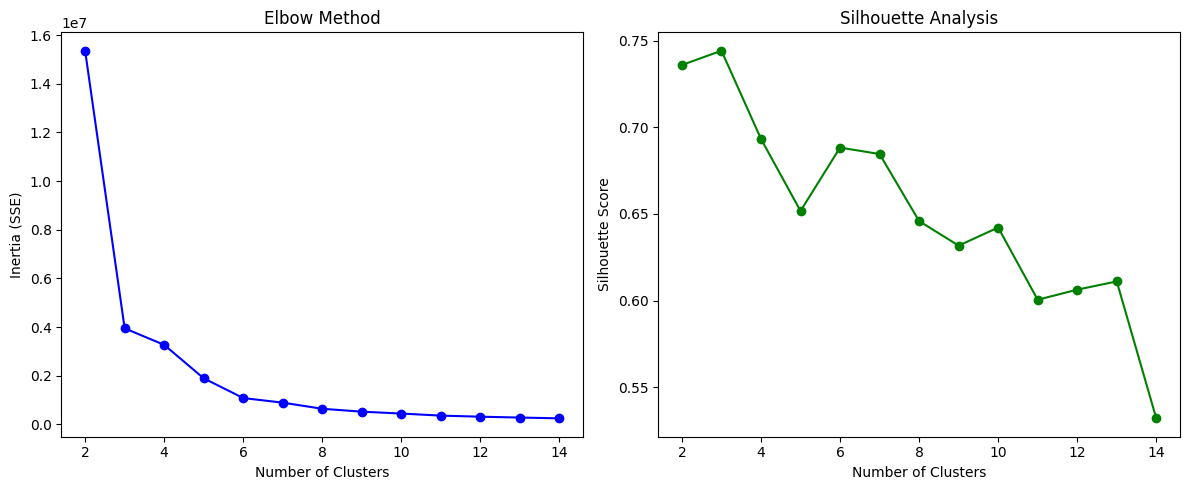

In [29]:
# Konversi ke array jika belum
X_dense = X_combined.toarray()

# Sampling untuk evaluasi awal
sample_idx = np.random.choice(X_dense.shape[0], size=10000, replace=False)
X_sample = X_dense[sample_idx]

K = range(2, 15)
inertia = []
silhouette = []

# Loop semua K
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(X_sample, kmeans.labels_)
    silhouette.append(sil_score)

# Plot Elbow & Silhouette
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, silhouette, 'go-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [30]:
# Pilih K dengan Silhouette Score tertinggi
best_k = K[np.argmax(silhouette)]
print("✅ Jumlah cluster dengan silhouette score tertinggi:", best_k)

# Fitting KMeans akhir ke seluruh data
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_combined)

# Simpan label cluster
df['Cluster_Label'] = kmeans.labels_

✅ Jumlah cluster dengan silhouette score tertinggi: 3


In [33]:
# Sampling untuk evaluasi kualitas cluster
sample_idx = np.random.choice(X_dense.shape[0], size=10000, replace=False)
X_eval = X_dense[sample_idx]
labels_eval = kmeans.labels_[sample_idx]

sil_score = silhouette_score(X_eval, labels_eval)
db_index = davies_bouldin_score(X_eval, labels_eval)

print("✅ Silhouette Score (sample):", sil_score)
print("✅ Davies-Bouldin Index (sample):", db_index)

✅ Silhouette Score (sample): 0.7419696215495425
✅ Davies-Bouldin Index (sample): 0.30964984407937274


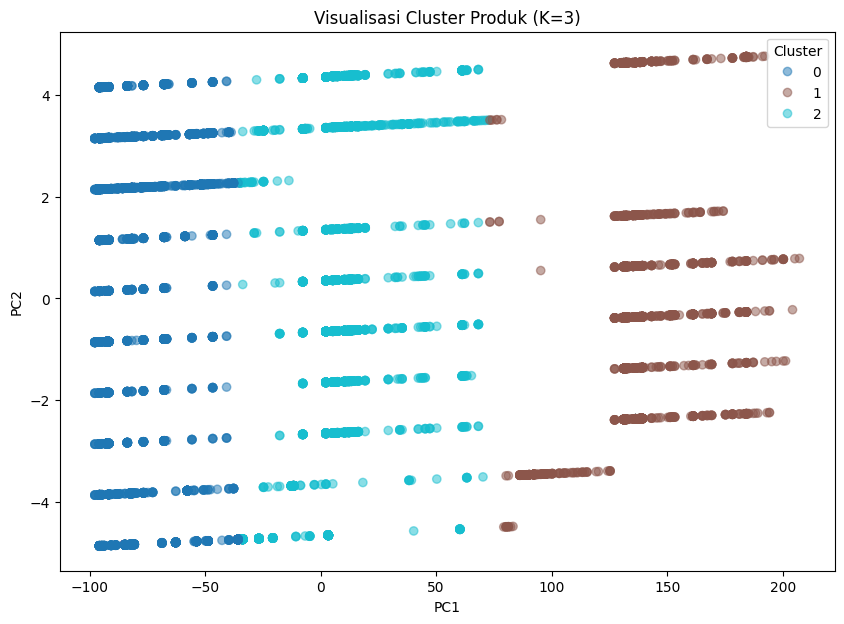

In [34]:
# PCA visualisasi 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_eval)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_eval, cmap='tab10', alpha=0.5)
plt.title(f'Visualisasi Cluster Produk (K={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [35]:
output_path = "/content/pricerunner_aggregate_clustered.csv"
df.to_csv(output_path, index=False, sep='\t')
print(f"Hasil clustering disimpan di {output_path}")

Hasil clustering disimpan di /content/pricerunner_aggregate_clustered.csv
